In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
import sys
import random
import tensorflow as tf
from pathlib import Path
from six.moves import urllib
import tarfile
import shutil

from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model

from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3


2024-01-01 23:45:30.323840: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-01 23:45:30.325494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-01 23:45:30.364655: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-01 23:45:30.365628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 23:45:31.072820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
target_size = (224, 224)

inception_model = InceptionV3(weights='imagenet', input_shape = target_size + (3,), include_top=False) #include_top=False excludes final FC layer

2024-01-01 23:45:32.088608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-01 23:45:32.089198: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

## Transfer Learning
- Adding 3 fully connected layers to learn new features for the image recognition task

In [4]:
flat_layer = layers.Flatten()(inception_model.output)
dense_layer_1 = layers.Dense(512, activation='relu')(flat_layer)
dense_layer_1 = layers.BatchNormalization()(dense_layer_1)
dense_layer_2 = layers.Dense(256, activation='relu')(dense_layer_1)
dense_layer_2 = layers.BatchNormalization()(dense_layer_2)
dense_layer_3 = layers.Dense(256, activation='relu')(dense_layer_2)

# next I specify which layers to 'freeze' and which layers to keep training
# freeze all convolutional InceptionV3 layers 
# and train only the layers I added at the top (initialized with random values)
for layer in inception_model.layers:
    layer.trainable = False

#define a model with the layers we've just connected
transfer_inception_model = Model(inputs = inception_model.inputs, outputs = dense_layer_3)

In [5]:
#our class will inherit from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer
class SimilarityLayer(layers.Layer):
    # compute and return the two distances:
    # d(anchor,positive) 
    # d(anchor,negative)
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, anchor, positive, negative):
        d1 = tf.reduce_sum(tf.square(anchor-positive), -1)
        d2 = tf.reduce_sum(tf.square(anchor-negative), -1)
        return(d1,d2)
    
anchor = layers.Input(name='anchor', shape = target_size + (3,))
positive = layers.Input(name='positive', shape = target_size + (3,))
negative = layers.Input(name='negative', shape = target_size + (3,))

sim_layer_output = SimilarityLayer().call(
    transfer_inception_model(inputs = inception_v3.preprocess_input(anchor)),
    transfer_inception_model(inputs = inception_v3.preprocess_input(positive)),
    transfer_inception_model(inputs = inception_v3.preprocess_input(negative))
)

siamese_model = Model(inputs=[anchor, positive,negative], outputs=sim_layer_output)


In [6]:
class SiameseModelClass(Model):
    def __init__(self, siamese_model, margin = 0.5):
        super(SiameseModelClass, self).__init__()
        
        self.siamese_model = siamese_model
        self.margin = margin
        
        # create a Metric instance to track the loss
        self.loss_tracker = metrics.Mean(name="loss")
        
    def call(self, inputs):
        return self.siamese_model(inputs)
    
    # customize the training process: providing our own training step
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # call custom loss function
            loss = self.custom_loss(data)
            
        # Compute gradients
        trainable_vars = self.siamese_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update our training loss metric
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    # providing our own evaluation step
    def test_step(self, data):
        # call custom loss function
        loss = self.custom_loss(data)
        
        # Update our test loss metric
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    # custom loss function
    def custom_loss(self, data):
        # get the distances tuple from the siamese model output
        d1, d2 = self.siamese_model(data)
        
        # compute the triplet loss
        loss = tf.maximum(d1 - d2 + self.margin, 0)
        
        return loss
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.loss_tracker]


In [7]:
def download_and_uncompress_tarball(tarball_url, dataset_dir):
    """Downloads the `tarball_url` and uncompresses it locally.
    Args:
    tarball_url: The URL of a tarball file.
    dataset_dir: The directory where the temporary files are stored.
    """
    filename = tarball_url.split('/')[-1]
    filepath = os.path.join(dataset_dir, filename)

    def _progress(count, block_size, total_size):
        sys.stdout.write('\r>> Downloading %s %.1f%%' % (
            filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()

    filepath, _ = urllib.request.urlretrieve(tarball_url, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    tarfile.open(filepath, 'r:gz').extractall(dataset_dir)


In [8]:
# URL for sourcing the funneled images
database_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'

root_folder = os.getcwd()
download_folder = root_folder + '/'+ 'data/lfw_original'
selection_folder = root_folder + '/' + 'data/lfw_selection'
download_path = download_folder + '/lfw-deepfunneled.tgz'

if not os.path.exists(download_folder):
    os.makedirs(download_folder)

if not os.path.exists(selection_folder):
    os.makedirs(selection_folder)
    
if not os.path.exists(download_path):
    download_and_uncompress_tarball(database_url, download_folder)


In [9]:
extracted_folder = download_folder + '/lfw-deepfunneled'

# images are organized into separate folders for each person
# get a list of subfolders 
subfolders = [x[0] for x in os.walk(extracted_folder)]

# first item is root the folder itself
subfolders.pop(0) 

'/home/banula/FYP/AI-Album-Notebooks/Federated-Transfer-Learning/data/lfw_original/lfw-deepfunneled'

In [10]:
people_list = []

for path in subfolders:
    image_count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    people_list.append((path.split('\\')[-1], image_count))
    #people_count.append((path, image_count))
    
# Sort from max to min images per person
people_list = sorted(people_list, key=lambda x: x[1], reverse=True)

In [11]:
print(f'Number of people: {len(subfolders)}')
print(f'Number of people with only one photo: {len([person for person, image_count in people_list if image_count==1])}')
print(f'Number of people with >=5 photos: {len([person for person, image_count in people_list if image_count>=5])}')

Number of people: 5749
Number of people with only one photo: 4069
Number of people with >=5 photos: 423


In [12]:
# dictionary of selected persons, where 
# - key = rank
# - value = list of names of the image files for this person
selected_persons = {}
i = 0

for person,image_count in people_list:
    if image_count >=5:
        file_list = []
        
        # create new folder in selected images path
        newpath = selection_folder + '/' + person.split('/')[-1]
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        
        # copy / paste first 5 images to the new location
        files = [os.path.join(person, f) for f in os.listdir(person) if os.path.isfile(os.path.join(person, f))]
        files = files[0:5] # select first 5 images
        for file in files:
            filename = file.split('/')[-1]
            shutil.copyfile(file, newpath + '/' + filename)
            file_list.append(newpath + '/' + filename)
            
        selected_persons[i] = file_list
        i = i + 1

In [13]:
triplets = []

for item in selected_persons.items():
    images = item[1]
    
    for i in range(len(images)-1):
        for j in range(i+1,len(images)):
            anchor = images[i]
            positive = images[j]
            
            # choose a random negative
            # first generate a random class rank and make sure we're not selecting the current class
            random_class = item[0]
            while random_class == item[0]:
                random_class = random.randint(0, len(selected_persons)-1)
            # selected a random image from the 5 that any of our classes has
            random_image = random.randint(0, 4)
            negative = selected_persons[random_class][random_image]
            
            triplets.append((anchor, positive, negative))


In [14]:
# helper function for needed preprocessing of our jpg images
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_size)
    return image

In [15]:
def plot_images(triplets):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    fig = plt.figure(figsize=(7,12))
    axis = fig.subplots(5, 3)
    
    for i in range(0,5):
        anchor,positive,negative = triplets[40+i]
        show(axis[i,0], preprocess_image(anchor))
        show(axis[i,1], preprocess_image(positive))
        show(axis[i,2], preprocess_image(negative))

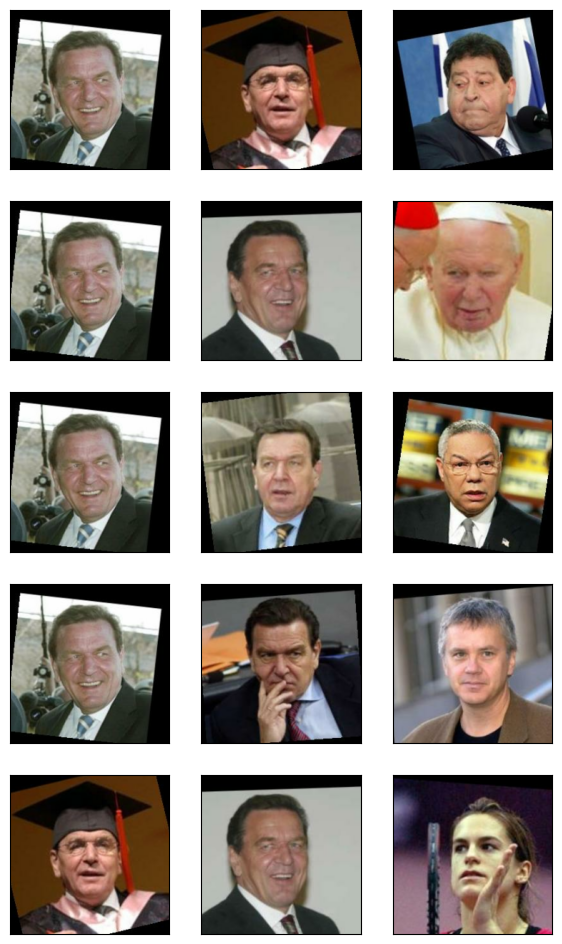

In [16]:
plot_images(triplets)

In [17]:
# helper function for transforming a tuple of filenames 
# into a tuple of corresponding tensors
def preprocess_triplets(anchor, positive, negative):
    """
    Inputs: a tuple of filenames
    Output: a tuple of preprocessed images 
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative)
    )

In [18]:
rng = np.random.RandomState(seed=101)
rng.shuffle(triplets)

In [19]:
anchor_images = [a_tuple[0] for a_tuple in triplets]
positive_images = [a_tuple[1] for a_tuple in triplets]
negative_images = [a_tuple[2] for a_tuple in triplets]

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

In [20]:
training_data = dataset.take(round(image_count * 0.8))
validation_data = dataset.skip(round(image_count * 0.8))

training_data = training_data.batch(32, drop_remainder=False)
training_data = training_data.prefetch(8)

validation_data = validation_data.batch(32, drop_remainder=False)
validation_data = validation_data.prefetch(8)

In [37]:
import time
start_time = time.time()

epochs = 15

siameze_custom_model = SiameseModelClass(siamese_model)
siameze_custom_model.compile(optimizer = optimizers.Adam(0.0001))
siameze_custom_model.fit(training_data, epochs=epochs, validation_data = validation_data)

stop_time = time.time()
print(f'It took {(stop_time - start_time)} to train for {epochs} epochs.')

Epoch 1/15
1/1 [==============================] - 144s 144s/step - loss: 0.1334 - val_loss: 0.8390
Epoch 2/15
1/1 [==============================] - 145s 145s/step - loss: 1.4355 - val_loss: 1.0629
Epoch 3/15
1/1 [==============================] - 148s 148s/step - loss: 0.0000e+00 - val_loss: 1.2755
Epoch 4/15
1/1 [==============================] - 142s 142s/step - loss: 0.0000e+00 - val_loss: 1.4772
Epoch 5/15
1/1 [==============================] - 136s 136s/step - loss: 0.0000e+00 - val_loss: 1.6701
Epoch 6/15
1/1 [==============================] - 138s 138s/step - loss: 9.5602 - val_loss: 1.2846
Epoch 7/15
1/1 [==============================] - 130s 130s/step - loss: 2.1893 - val_loss: 1.1542
Epoch 8/15
1/1 [==============================] - 134s 134s/step - loss: 4.2338 - val_loss: 1.1141
Epoch 9/15
1/1 [==============================] - 147s 147s/step - loss: 1.5266 - val_loss: 1.1103
Epoch 10/15
1/1 [==============================] - 137s 137s/step - loss: 0.0000e+00 - val_loss: 

In [40]:
sample = next(iter(training_data))
#plot_images(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    transfer_inception_model(inputs = inception_v3.preprocess_input(anchor)),
    transfer_inception_model(inputs = inception_v3.preprocess_input(positive)),
    transfer_inception_model(inputs = inception_v3.preprocess_input(negative)),
)

In [41]:
d1 = np. sum(np. power((anchor_embedding-positive_embedding),2))
print(f'Anchor-positive difference = {d1}')

d2 = np. sum(np. power((anchor_embedding-negative_embedding),2))
print(f'Anchor-negative difference = {d2}')

Anchor-positive difference = 6.331628322601318
Anchor-negative difference = 10.161787033081055


In [42]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.9835967
Negative similarity 0.9688685


In [43]:
siameze_custom_model.save('siameze_custom_model.keras')

/home/banula/mambaforge/envs/aialbum/lib/python3.10/site-packages/keras/src/saving/saving_api.py:146: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)
